# Parte 4: Clasificación de Tickets usando NLP

El modelado busca desarrollar clasificadores que automaticen el triage de tickets de soporte a partir del texto libre. Esta etapa es fundamental para traducir la información no estructurada en decisiones útiles para el negocio. Los objetivos principales son:

- Entrenar modelos supervisados que aprendan a predecir la categoría de un ticket en base a su descripción textual.
- Comparar dos enfoques: uno tradicional basado en TF-IDF + modelo clásico (Logistic Regression) y otro moderno basado en el fine-tuning de DistilBERT.
- Evaluar el rendimiento de ambos enfoques utilizando métricas como precisión, recall y F1-score.
- Detectar fortalezas y limitaciones de cada método para entender cuál se adapta mejor al problema.
- Identificar oportunidades de mejora y ajustes en el pipeline de procesamiento y modelado.
- Seleccionar el modelo más robusto para su futura implementación como sistema automatizado de clasificación.

| **Columna**               | **Descripción**                                                                                                       |
| ------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| **Ticket Description**    | Texto con la descripción del problema reportado por el usuario.                                                       |
| **Ticket Priority**       | Prioridad asignada al ticket (por ejemplo: `Critical`, `High`, `Medium`, `Low`).                                      |
| **Ticket Channel**        | Canal por el cual se reportó el ticket (por ejemplo: `Email`, `Chat`, `Phone`, `Social media`).                       |
| **Urgency**               | Valor numérico que indica si el ticket fue considerado urgente (`1`) o no (`0`).                                      |
| **Resolution\_Time\_Bin** | Bin/categoría (numérica) que indica en qué rango de tiempo fue o debería ser resuelto (todos parecen `0` o `1` aquí). |
| **Urgency\_from\_Text**   | Urgencia inferida automáticamente a partir del texto del ticket (`0` o `1`).                                          |
| **Coincide**              | `True` o `False` indicando si la urgencia inferida desde el texto coincide con la urgencia real.                      |
| **Urgency\_Final**        | Urgencia final determinada tras combinar las anteriores (`0` o `1`).                                                  |


### Importar librerías y Configuración Inicial

In [1]:
#Incluya las principales librerias a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

# Carga de datos

In [3]:
data = pd.read_csv("C:/Users\ASUS/CC219-TP-TF-2024-2--CC92/data/data_limpia2.csv")

In [4]:
data.head()

,Ticket Description,Ticket Priority,Ticket Channel,Urgency,Resolution_Time_Bin,Urgency_from_Text,Coincide,Urgency_Final
0,bill code appreciate request website address d...,Critical,Social media,1,0,0,False,1
1,need change exist product face intermittent so...,Critical,Chat,1,0,0,False,1
2,face problem turn work fine yesterday doesnt r...,Low,Social media,0,0,0,True,0
3,problem youre interested love see happen check...,Low,Social media,0,0,0,True,0
4,note seller responsible damage delry game game...,Low,Email,0,0,0,True,0


In [83]:
data['Ticket Priority'].unique()


array(['Critical', 'Low', 'High', 'Medium'], dtype=object)

In [5]:
data.drop(columns=['Urgency','Resolution_Time_Bin','Urgency_from_Text','Coincide'],inplace=True)

verificar si hay nulos

In [7]:
data.isnull().sum()

Ticket Description    3
Ticket Priority       0
Ticket Channel        0
Urgency_Final         0
dtype: int64

In [9]:
data[data['Ticket Description'].isnull()]

,Ticket Description,Ticket Priority,Ticket Channel,Urgency_Final
1357,NaN,High,Chat,1
2566,NaN,Medium,Social media,0
4587,NaN,High,Email,1


In [13]:
data.dropna(inplace=True)

verificar si hay duplicados

In [8]:
data.duplicated().sum()

np.int64(358)

In [12]:
duplicados_conteo = data[data.duplicated()].groupby(data.columns.tolist()).size().reset_index(name='Repeticiones')
print(duplicados_conteo)

                                    Ticket Description Ticket Priority  \
0    already contact customer support multiple time...        Critical   
1    already contact customer support multiple time...        Critical   
2    already contact customer support multiple time...        Critical   
3    already contact customer support multiple time...        Critical   
4    already contact customer support multiple time...            High   
..                                                 ...             ...   
188  worried might hardwarerelated might require re...        Critical   
189  worried might hardwarerelated might require re...        Critical   
190  worried might hardwarerelated might require re...             Low   
191  worried might hardwarerelated might require re...             Low   
192  worried might hardwarerelated might require re...          Medium   

    Ticket Channel  Urgency_Final  Repeticiones  
0             Chat              1             1  
1          

In [14]:
data.drop_duplicates(inplace=True)

verificar si ya no hay ningun nulo o duplicado

In [15]:
print("Nulos por columna:\n", data.isnull().sum())
print("\nCantidad de duplicados:", data.duplicated().sum())

Nulos por columna:
 Ticket Description    0
Ticket Priority       0
Ticket Channel        0
Urgency_Final         0
dtype: int64

Cantidad de duplicados: 0


# Dividir en entramiento y prueba

nuevas librerias que usare

In [32]:
import spacy
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

cargar el modelo de ingles de spacy

In [36]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 487.6 kB/s eta 0:00:27
     --------------------------------------- 0.0/12.8 MB 487.6 kB/s eta 0:00:27
     --------------------------------------- 0.0/12.8 MB 487.6 kB/s eta 0:00:27
     --------------------------------------- 0.0/12.8 MB 487.6 kB/s eta 0:00:27
     --------------------------------------- 0.1/12.8 MB 148.8 kB/s eta 0:01:26
     --------------------------------------- 0.1/12.8 MB 163.8 kB/s eta 0:01:18
     --------------------------------------- 0.1/12.8 MB 163.8 kB/s eta 0:01:18
     --------------------------------------- 0.1/12.8 MB 163.8 kB/s eta 0:01:18
     --------------------------------------- 0.1/12.8 MB 163.8 kB/s eta 0:01:18
     --------------------------------------- 0.1/12.8 MB 163.8 kB/s eta 0:01:18
     --------------------------------------- 0.1/12.8 MB


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
nlp = spacy.load("en_core_web_sm")

funcion de limpieza y lematizacion

In [38]:
def spacy_preprocessor(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    return " ".join(tokens)

TF - IDF con funcion de preprocesamiento personalizado

In [39]:
tfidf = TfidfVectorizer(
    max_features=500,
    preprocessor=spacy_preprocessor
)

separar features y target

In [40]:
X = data[['Ticket Description', 'Ticket Priority', 'Ticket Channel']]
y = data['Urgency_Final']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# ColumnTransformer para texto + variables categóricas

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf, 'Ticket Description'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Ticket Priority', 'Ticket Channel'])
    ]
)

#  Modelos

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [66]:
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

In [60]:
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (linear)': SVC(probability=True, kernel='linear', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [72]:
resultados = []
pipelines_entrenados = {}

# Entrenar


 Modelo: Random Forest

 Modelo: Logistic Regression

 Modelo: SVM (linear)

 Modelo: XGBoost


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:25:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


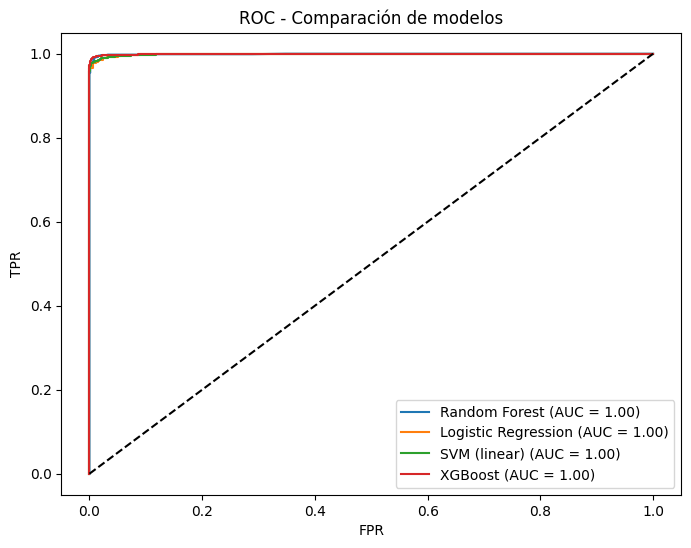

In [74]:
plt.figure(figsize=(8,6))

for nombre, modelo in modelos.items():
    print(f"\n Modelo: {nombre}")
    
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('clf', modelo)
    ])
    
    pipeline.fit(X_train, y_train)
    pipelines_entrenados[nombre] = pipeline  # guardamos este pipeline
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # métricas
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=[0,1]
    )
    acc = accuracy_score(y_test, y_pred)
    
    resultados.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Precision_0': precision[0],
        'Recall_0': recall[0],
        'F1_0': f1[0],
        'Precision_1': precision[1],
        'Recall_1': recall[1],
        'F1_1': f1[1],
        'AUC': roc_auc
    })
    
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC - Comparación de modelos")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# Tabla de resumen

In [75]:
df_resultados = pd.DataFrame(resultados)

In [76]:
print("\n📋 Resumen de métricas:\n")
print(df_resultados.sort_values(by='AUC', ascending=False))


📋 Resumen de métricas:

                Modelo  Accuracy  Precision_0  Recall_0      F1_0  \
3              XGBoost  0.991985     0.990528  0.991870  0.991198   
0        Random Forest  0.989519     0.985195  0.991870  0.988521   
2         SVM (linear)  0.985203     0.973475  0.994580  0.983914   
1  Logistic Regression  0.982121     0.968296  0.993225  0.980602   

   Precision_1  Recall_1      F1_1       AUC  
3     0.993205  0.992081  0.992643  0.999532  
0     0.993174  0.987557  0.990357  0.999272  
2     0.995392  0.977376  0.986301  0.999044  
1     0.994220  0.972851  0.983419  0.999028  


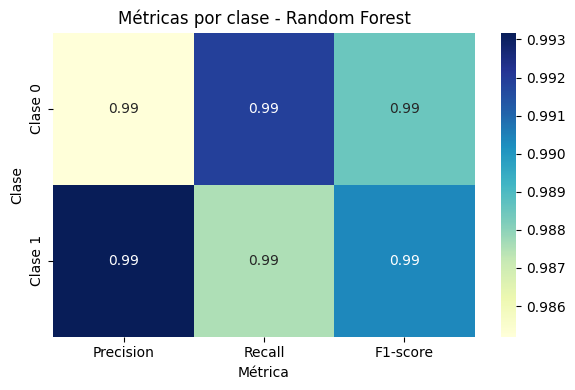

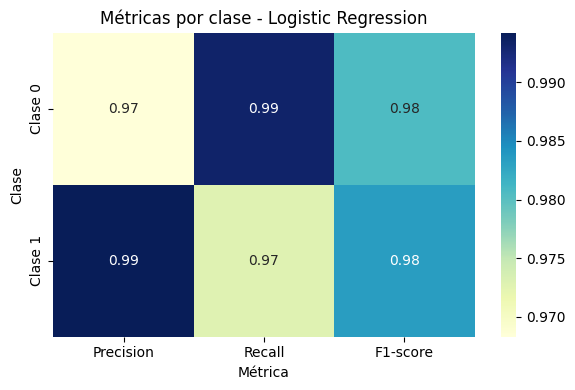

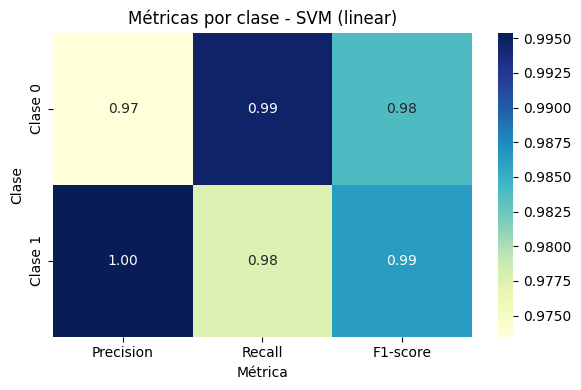

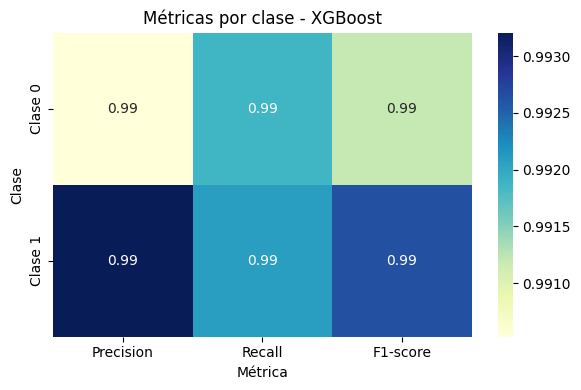

In [ ]:
for _, fila in df_resultados.iterrows():
    modelo = fila['Modelo']
    métricas = {
        'Clase 0': {
            'Precision': fila['Precision_0'],
            'Recall': fila['Recall_0'],
            'F1-score': fila['F1_0']
        },
        'Clase 1': {
            'Precision': fila['Precision_1'],
            'Recall': fila['Recall_1'],
            'F1-score': fila['F1_1']
        }
    }

    df_métricas = pd.DataFrame(métricas).T

    plt.figure(figsize=(6,4))
    sns.heatmap(df_métricas, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title(f'Métricas por clase - {modelo}')
    plt.ylabel('Clase')
    plt.xlabel('Métrica')
    plt.tight_layout()
    plt.show()

Elegimos el mejor resultado

In [79]:
mejor_nombre = df_resultados.sort_values(by='AUC', ascending=False).iloc[0]['Modelo']
print(f"\n Mejor modelo según AUC: {mejor_nombre}")


 Mejor modelo según AUC: XGBoost


In [80]:
import joblib

In [81]:
joblib.dump(pipelines_entrenados[mejor_nombre], "mejor_modelo_urgencia.pkl")
print(f" Guardado como: mejor_modelo_urgencia.pkl")


 Guardado como: mejor_modelo_urgencia.pkl
